# Rossmann Store
---

## IMPORTS

In [1]:
# loading packages
from IPython.core.display import HTML
from IPython.core.display import Image
import inflection
import json
import pickle
import random
import requests
import warnings

# data manipulation
import datetime as dt
import math
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

# data visualization
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

# data preprocessing
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

# feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

# machine learning
from sklearn.linear_model import Lasso, LinearRegression
import xgboost as xgb

# model evaluation
from scipy import stats as ss
from sklearn.metrics import mean_absolute_error, mean_squared_error

## HELPER FUNCTIONS

### Analytical

In [2]:
# snakecase
def snakecase(x):
    return inflection.underscore(x)

# ignoring errors
warnings.filterwarnings('ignore')

# round
pd.options.display.float_format = '{:.5f}'.format

### Graphic

In [3]:
# colors used in the project
red = '#F15854'
blue = '#5DA5DA'
orange = '#FAA43A'
green = '#60BD68'
pink = '#F17CB0'
brown = '#B2912F'
purple = '#B276B2'
yellow = '#DECF3F'
gray = '#4D4D4D'

#dataframes looks pretty to me
def change_df(data):
    return pd.DataFrame(data)


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'seaborn-pastel' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

    
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

Populating the interactive namespace from numpy and matplotlib


### Metric

In [4]:
def numerical_metrics(numerical_attributes):
    data_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    data_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    data_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    data_min = pd.DataFrame(numerical_attributes.apply(min)).T
    data_max = pd.DataFrame(numerical_attributes.apply(max)).T
    data_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    data_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    data_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    num_attributes = pd.concat([data_min,data_max,data_range,data_mean,data_median,data_std,data_skew,data_kurtosis]).T.reset_index()
    num_attributes.columns=['Attributes','Min','Max','Range','Mean','Median','St deviation','Skewness','Kurtosis']

    return num_attributes

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max(
        ) - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max(
        ) - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (
            x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


def cramers_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

## DATA

- **Data fields**
    - Id - an Id that represents a (Store, Date) duple within the test set
    - Store - a unique Id for each store
    - Sales - the turnover for any given day (this is what you are predicting)
    - Customers - the number of customers on a given day
    - Open - an indicator for whether the store was open: 0 = closed, 1 = open
    - StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
    - SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
    - StoreType - differentiates between 4 different store models: a, b, c, d
    - Assortment - describes an assortment level: a = basic, b = extra, c = extended
    - CompetitionDistance - distance in meters to the nearest competitor store
    - CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
    - Promo - indicates whether a store is running a promo on that day
    - Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
    - Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
    - PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [5]:
# df = dataframe
# raw = without any modificantion
# read_csv is a function used with pandas library
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 1.0 DATA DESCRIPTION

- **Tasks**
    - Dataset checkpoint
    - Rename Columns
    - Data Dimensions
    - Data Types
    - Check missing values
    - Fillout missing values
    - Change Types
    - Descriptive Statistical

### 1.1 Checkpoint

In [6]:
df1 = df_raw.copy()

### 1.2 Rename Columns

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

The snake case pattern will be used in this project as a name convention in the columns names. An example is:

**StateHoliday = state_holiday** 

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

#using the snakecase type
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

### 1.3 Data Dimensions

In [9]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 1017209 
Number of columns: 18


### 1.4 Data Types

we can see that the column date is an object, so, we'll change it to a 'datetime'.

In [10]:
#changing the date type from object to datetime
df1['date'] = pd.to_datetime(df1['date'])
change_df(df1.dtypes)

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


### 1.5 Check missing values

Dealing with NA is an extremely important step in data science, we can solve this with the ways
    - Exclude null values;
    - Replace with central tendecy parameters like median;
    - Change with a knowledge of the business problem;

The first one is the most dangerous, if we remove these lines, we'll lose amount of data and can be pretty bad in the machine learning modelling.

In [11]:
change_df(df1.isna().sum())

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


### 1.6 Fillout missing values

**The changes used are:**

- competition_distance: Replaced the missing values with a huge distance, just to tell us that there are no competitors near.

- competition_open_since_month: Replaced with the month of the date column.
  
- competition_open_since_year: Replaced with the year of the date column.
   
- promo2_since_week: Replaced by the week from the date column.
    
- promo2_since_year: Replaced by the year from the date column.
    
- promo_interval: Replaced the null values with 0 and checked if the store participated in promo2 or not represented by 0 and 1. 

In [12]:
# competition_distance
# for complete the NaN elements, just apply a lambda function with a value > df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 2000000.0 if math.isnan(x) else x)

# competition_open_since_month
# change the NaN elements to date
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(
    x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
# equal to competition_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(
    x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['promo2_since_year']) else x['promo2_since_year'], axis=1)


#promo_interval
#Changing names of month to numbers makes the manipulation easier
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',
             7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

#there's a list, use .map instead of .apply
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
change_df(df1.isnull().sum())

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


### 1.7 Change Types

**Changed the types to:**
- "competition_open_since_month" and "competition_open_since_year" to "int" 
- "promo2_since_week" and "promo2_since_year" to "int".

In [14]:
#converting competition_open_since_month, competition_open_since_year, promo2_since_week, promo2_since_year  from float to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(
    int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.8 Descriptive Statistics 

This step separate the numerical attributes and the categorical attributes, each one has a different form of analysis.

In [15]:
num_cols = df1.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_cols = cat_attributes.columns.tolist()

#### 1.8.1 Numerical attributes

- Central tendency
  - average 
  - median
---

- Dispersion 
  - standard deviation: tell us the variation, for                             example, if the median is 350                           and the std is 100, there times                         that the total 350+100 and                             times that the total is 350-                           100;
  
  - min: min value of all the data;
  
  - max: max value of all the data;
  
  - range- difference between min and max;
  
  - skewness: tell us how shifted our graph is.
  
  - kurtosis: tell us how close our distribution is to a normal distribution.

In [16]:
num_attributes = numerical_metrics(df1[num_cols])
num_attributes

,Attributes,Min,Max,Range,Mean,Median,St deviation,Skewness,Kurtosis
0,store,1.00000,1115.00000,1114.00000,558.42973,558.00000,321.90849,-0.00095,-1.20052
1,day_of_week,1.00000,7.00000,6.00000,3.99834,4.00000,1.99739,0.00159,-1.24687
2,sales,0.00000,41551.00000,41551.00000,5773.81897,5744.00000,3849.92428,0.64146,1.77837
3,customers,0.00000,7388.00000,7388.00000,633.14595,609.00000,464.41151,1.59865,7.09177
4,open,0.00000,1.00000,1.00000,0.83011,1.00000,0.37554,-1.75804,1.09072
5,promo,0.00000,1.00000,1.00000,0.38151,0.00000,0.48576,0.48784,-1.76202
6,school_holiday,0.00000,1.00000,1.00000,0.17865,0.00000,0.38306,1.67784,0.81515
7,competition_distance,20.00000,2000000.00000,1999980.00000,10610.58810,2330.00000,101810.64910,19.37800,375.64440
8,competition_open_since_month,1.00000,12.00000,11.00000,6.78685,7.00000,3.31109,-0.04208,-1.23261
9,competition_open_since_year,1900.00000,2015.00000,115.00000,2010.32484,2012.00000,5.51559,-7.23566,124.07130


In [17]:
df1[num_cols].describe()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
count,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000,1017209.00000
mean,558.42973,3.99834,5773.81897,633.14595,0.83011,0.38151,0.17865,10610.58810,6.78685,2010.32484,0.50056,23.61903,2012.79330,0.15523
std,321.90865,1.99739,3849.92618,464.41173,0.37554,0.48576,0.38306,101810.69914,3.31109,5.51559,0.50000,14.31006,1.66266,0.36212
min,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,20.00000,1.00000,1900.00000,0.00000,1.00000,2009.00000,0.00000
25%,280.00000,2.00000,3727.00000,405.00000,1.00000,0.00000,0.00000,710.00000,4.00000,2008.00000,0.00000,12.00000,2012.00000,0.00000
50%,558.00000,4.00000,5744.00000,609.00000,1.00000,0.00000,0.00000,2330.00000,7.00000,2012.00000,1.00000,22.00000,2013.00000,0.00000
75%,838.00000,6.00000,7856.00000,837.00000,1.00000,1.00000,0.00000,6910.00000,10.00000,2014.00000,1.00000,37.00000,2014.00000,0.00000
max,1115.00000,7.00000,41551.00000,7388.00000,1.00000,1.00000,1.00000,2000000.00000,12.00000,2015.00000,1.00000,52.00000,2015.00000,1.00000


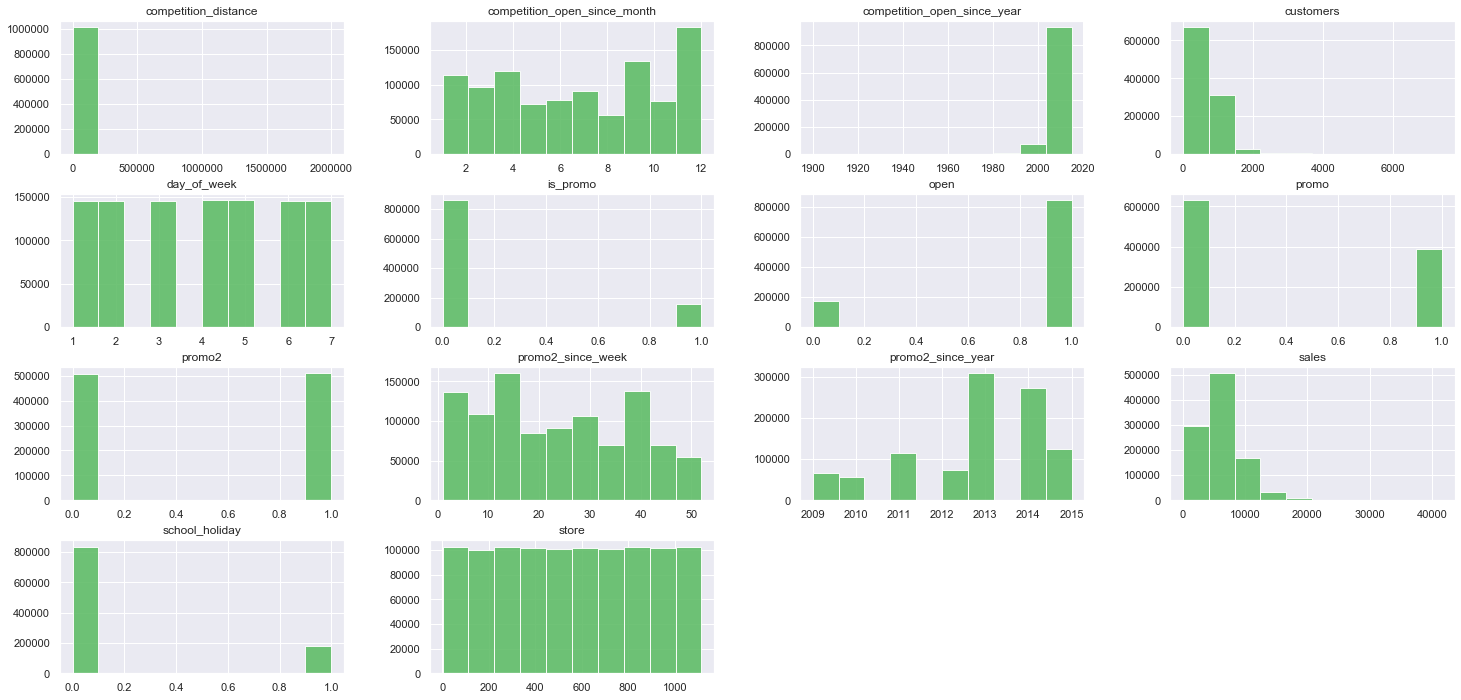

In [18]:
df1[num_cols].hist(bins=10, alpha=0.9, color=green);

#### 1.8.2 Categorical attributes

In [19]:
#list of categorical attributes
change_df(cat_attributes.apply(lambda x: x.unique().shape[0]))


,0
state_holiday,4
store_type,4
assortment,3
promo_interval,4
month_map,12


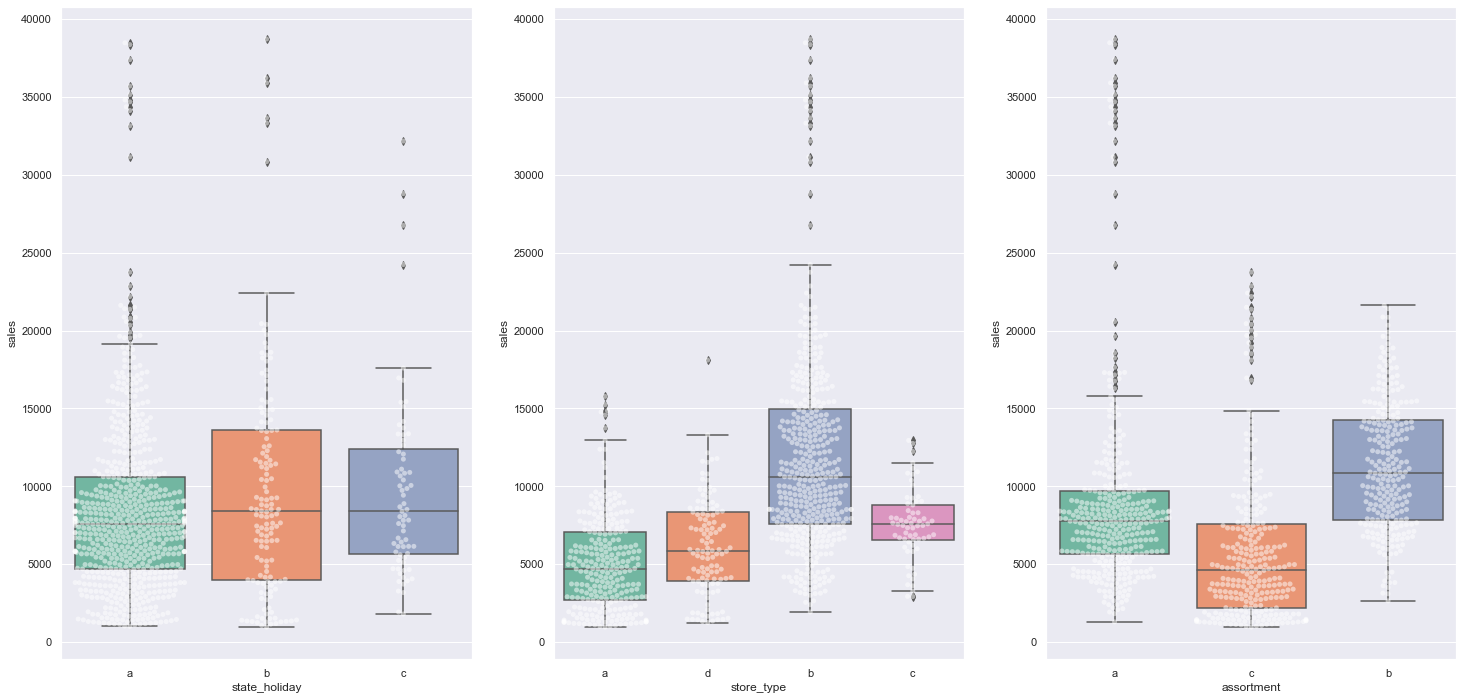

In [20]:
#conditions
#we don't want to see the days when the stores were closed
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# creating subplots
fig, ax = plt.subplots()

plt.subplot(1, 3, 1)
ax = sns.boxplot(x='state_holiday', y='sales', data=aux1, palette='Set2')
ax = sns.swarmplot(x='state_holiday', y='sales', data=aux1, color='white', alpha=0.5)

plt.subplot(1, 3, 2)
ax = sns.boxplot(x='store_type', y='sales', data=aux1, palette='Set2')
ax = sns.swarmplot(x='store_type', y='sales', data=aux1, color='white', alpha=0.5)

plt.subplot(1, 3, 3)
ax = sns.boxplot(x='assortment', y='sales', data=aux1, palette='Set2')
ax = sns.swarmplot(x='assortment', y='sales', data=aux1, color='white', alpha=0.5)

# displays plot
plt.show();

## 2.0 FEATURE ENGINEERING

- **Tasks**
    - Dataset Checkpoint
    - Mindmap
    - Hypothesis
    - Feature Engineering To Validate Our Hypothesis

### 2.1 Checkpoint

In [21]:
df2 = df1.copy()

### 2.2 Mind Map

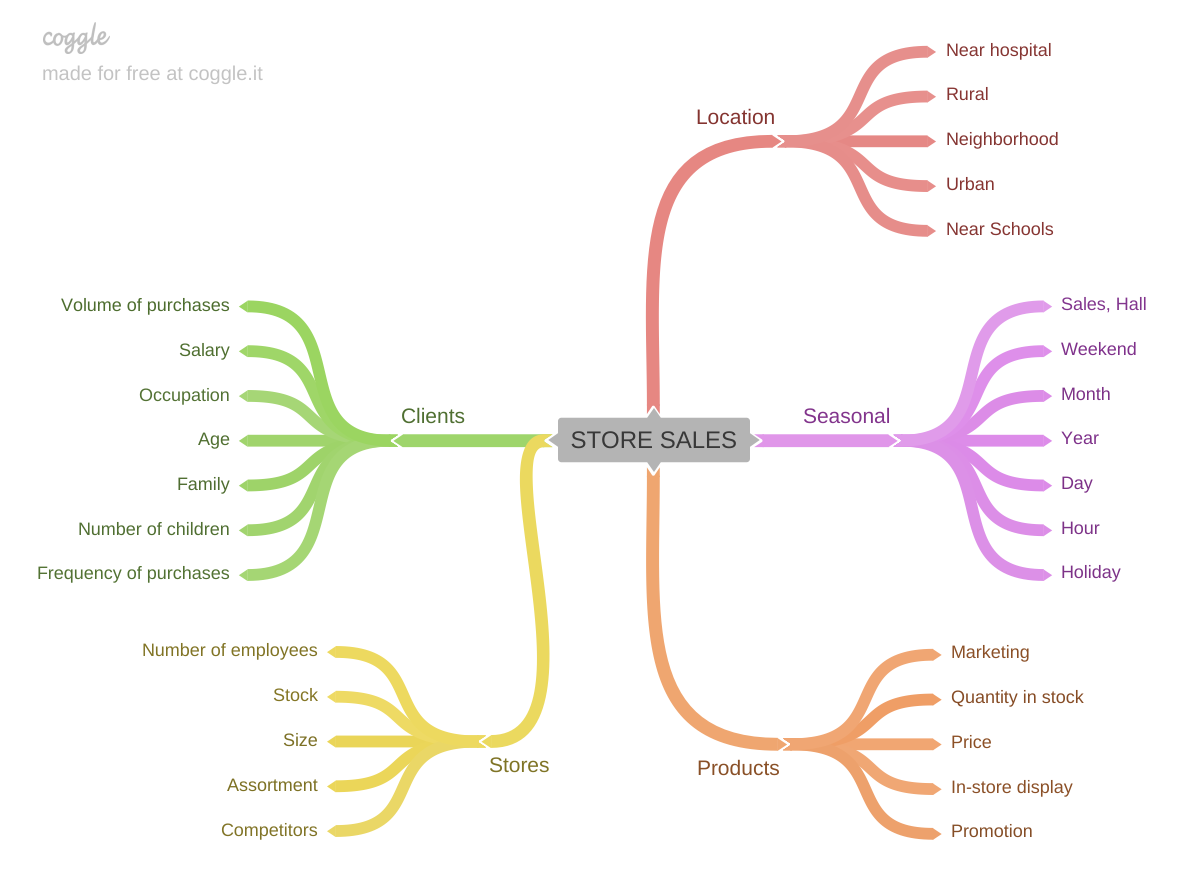

In [22]:
Image('img/mind_map_hypothesis.png')

### 2.3 Hypothesis creation

#### 2.3.1 Store's hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with more stock capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5** Stores with closer competitors should sell less.

**6** Stores dealing with competitors for a long time should sell more.

#### 2.3.2 Product's hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with a huge product exposure should sell more.

**3.** Stores with lower priced products should sell more should sell more.

**4.** Stores with more aggressive promotions (bigger discounts), should sell more.

**5.** Stores with active promotions for more time should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

#### 2.3.3 Seasonal's hypothesis

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more after the 10th of each month.

**4.** Stores should sell more in the second half of the year.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

### 2.4 Hypothesis final list

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more after the 10th of each month.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

### 2.5 Feature Engineering To Validate Our Hypothesis

We'll create these features:
- year
- month
- day
- week of day
- year week

And we'll modify some to be more easy to read in 'state_holiday' and 'assortment'.

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#  year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
    year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = (
    (df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(
    x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = (
    (df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

## 3.0 VARIABLE FILTERING

- **Tasks**
    - Dataset Checkpoint
    - Filtering Rows
    - Filtering Columns

### 3.1 Checkpoint

In [24]:
df3 = df2.copy()

In [25]:
df3.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
880649,585,5,2013-05-03,7742,1155,1,1,regular_day,0,d,extended,440.00000,4,2014,0,18,2013,0,May,0,2013,5,3,18,2013-17,2014-04-01,-12,2013-04-29,0
158721,392,3,2015-03-11,6473,655,1,0,regular_day,0,a,basic,2120.00000,3,2015,0,11,2015,0,Mar,0,2015,3,11,11,2015-10,2015-03-01,0,2015-03-09,0
556543,944,2,2014-02-18,7514,1116,1,1,regular_day,0,c,basic,1670.00000,7,2015,0,8,2014,0,Fev,0,2014,2,18,8,2014-07,2015-07-01,-17,2014-02-17,0
768457,1008,1,2013-08-12,8637,1035,1,1,regular_day,0,a,extended,30.00000,9,2010,0,33,2013,0,Aug,0,2013,8,12,33,2013-32,2010-09-01,35,2013-08-12,0
482045,36,5,2014-04-25,7164,896,1,0,regular_day,1,a,extended,540.00000,6,2003,1,40,2014,"Jan,Apr,Jul,Oct",Apr,1,2014,4,25,17,2014-16,2003-06-01,132,2014-09-29,-23


### 3.2 Filtering Rows

We will remove the data in the columns 'open' and 'sales' that the value is 0, this number means that the store was closed and, because of that, there were no sales.

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.3 Filtering Columns

- Costumer: To use this column, we need to create a model to predict customers. Therefore,right now, it will not help us.

- Open - We've removed all the lines that have the value "0", so there's no variation. This columns won't be usefull.
- Promo_interval / "month_map" - We will remove it because we used it to build columns that will give to us the same information.

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.0 EXPLORATORY DATA ANALYSIS

### 4.1 Checkpoint

In [29]:
df4 = df3.copy()

## 5.0 DATA PREPARATION

### 5.1 Checkpoint

## 6.0 FEATURE SELECTION

### 6.1 Checkpoint

## 7.0 MACHINE LEARNING MODELS

## 8.0 HYPERPARAMETER FINE TUNING